In [11]:
# ruff: noqa
import sys, os
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))


# ruff: noqa
from feedback_grape.fgrape import evaluate_on_longer_time, Gate
from feedback_grape.utils.operators import (
    identity,
    sigmax,
    sigmay,
    sigmaz,
)
from feedback_grape.utils.states import (
    basis,
)
from feedback_grape.utils.tensor import tensor
from helpers import (
    init_decay_gate_analytical,
    generate_random_bloch_state,
    generate_random_discrete_state
)
import jax
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm

N_chains = 3 # Number of chains
num_povm = 2 # Number of POVM measurements per time step
gamma = 0.05 # Decay rate
eval_time_steps = 200 # Number of time steps for evaluation
eval_batch_size = 256 # Batch size for evaluation
rho = lambda key: generate_random_discrete_state(key, N_chains, noise_level=0.0)

# Selection of states and operators
def negative(M):
    return jnp.sqrt(identity(M.shape[0]) - M)

N = 2**N_chains # Hilbert space dimension
psi_00 = basis(N, 3)
psi_01 = basis(N, 2)
psi_10 = basis(N, 1)
psi_11 = basis(N, 0)
I = identity(N)
I2 = identity(2)
O = jnp.zeros((N,N))

# Pauli operators on three qubits
Z1 = tensor(sigmaz(), I2, I2)
Z2 = tensor(I2, sigmaz(), I2)
Z3 = tensor(I2, I2, sigmaz())
X1 = tensor(sigmax(), I2, I2)
X2 = tensor(I2, sigmax(), I2)
X3 = tensor(I2, I2, sigmax())
Y1 = tensor(sigmay(), I2, I2)
Y2 = tensor(I2, sigmay(), I2)
Y3 = tensor(I2, I2, sigmay())

# Stabilizers
S1 = Z1 @ Z2
S2 = Z2 @ Z3

M1_p = (I + S1)/2
M1_m = (I - S1)/2
M2_p = (I + S2)/2
M2_m = (I - S2)/2

# Error correction protocol to test
protocols = [
    {
        "label": "Do nothing",
        # povms for first time step
        "povm1_init_+": I / 2**0.5,
        "povm1_init_-": I / 2**0.5,
        "povm2_++": I / 2**0.5,
        "povm2_+-": I / 2**0.5,
        "povm2_-+": I / 2**0.5,
        "povm2_--": I / 2**0.5,
        # povms for all subsequent time steps
        "povm1_+++": I / 2**0.5,
        "povm1_++-": I / 2**0.5,
        "povm1_+-+": I / 2**0.5,
        "povm1_+--": I / 2**0.5,
        "povm1_-++": I / 2**0.5,
        "povm1_-+-": I / 2**0.5,
        "povm1_--+": I / 2**0.5,
        "povm1_---": I / 2**0.5,
        "povm2_+++": I / 2**0.5,
        "povm2_++-": I / 2**0.5,
        "povm2_+-+": I / 2**0.5,
        "povm2_+--": I / 2**0.5,
        "povm2_-++": I / 2**0.5,
        "povm2_-+-": I / 2**0.5,
        "povm2_--+": I / 2**0.5,
        "povm2_---": I / 2**0.5,
        # unitaries for all measurement outcomes
        "U_++": I,
        "U_+-": I,
        "U_-+": I,
        "U_--": I,
    },{
        "label": "Stabilizer code",
        # povms for first time step
        "povm1_init_+": M1_p,
        "povm1_init_-": M1_m,
        "povm2_++": M2_p,
        "povm2_+-": M2_m,
        "povm2_-+": M2_p,
        "povm2_--": M2_m,
        # povms for all subsequent time steps
        "povm1_+++": M1_p,
        "povm1_++-": M1_m,
        "povm1_+-+": M1_p,
        "povm1_+--": M1_m,
        "povm1_-++": M1_p,
        "povm1_-+-": M1_m,
        "povm1_--+": M1_p,
        "povm1_---": M1_m,
        "povm2_+++": M2_p,
        "povm2_++-": M2_m,
        "povm2_+-+": M2_p,
        "povm2_+--": M2_m,
        "povm2_-++": M2_p,
        "povm2_-+-": M2_m,
        "povm2_--+": M2_p,
        "povm2_---": M2_m,
        # unitaries for all measurement outcomes
        "U_++": I,
        "U_+-": X3,
        "U_-+": X1,
        "U_--": X2,
    },
]

[ # For later use
    {
        "label": "Zeno effect |00><00|",
        "povm_init_p": negative(P_00),
        "povm_init_m": P_00,
        "povm_p_p": negative(P_00),
        "povm_p_m": P_00,
        "povm_m_p": negative(P_00),
        "povm_m_m": P_00,
        "U_p": I,
        "U_m": I,
    },
    {
        "label": "Avoid |00><00|",
        "povm_init_p": I,
        "povm_init_m": O,
        "povm_p_p": negative(P_00),
        "povm_p_m": P_00,
        "povm_m_p": I,
        "povm_m_m": O,
        "U_p": I, # When not in |00>, do nothing
        "U_m": (
            1/2**0.5*(psi_01 + psi_10) @ (psi_00).conj().T # |00> --> (|01> + |10>)/sqrt(2)
            + 1/2**0.5*psi_11@(psi_01 + psi_10).conj().T # (|01> + |10>)/sqrt(2) --> |11>
            + 1/2**0.5*(psi_01 - psi_10)@psi_11.conj().T # (|11> --> |01> - |10>)/sqrt(2)
            + 1/2**0.5*psi_00@(psi_01 - psi_10).conj().T # (|01> - |10>)/sqrt(2) --> |00>
        )
    }
]

# Validate parameters
def check_povm(povm_p, povm_m):
    assert jnp.allclose(povm_p.conj().T @ povm_p + povm_m.conj().T @ povm_m, identity(povm_p.shape[0])), "Povm operators do not sum to identity."
def check_unitary(U):
    assert jnp.allclose(U.conj().T @ U, identity(U.shape[0])), "Unitary operator is not unitary."

for i, protocol in enumerate(protocols):
    for key, value in protocol.items():
        if key[:4] == "povm" and key[-1] == "+":
            check_povm(value, protocol[f"{key[:-1]}-"])
        elif key[0] == "U":
            check_unitary(value)

In [12]:
# Construct lookup table for protocol
def lut_from_protocol(protocol, use_analytical_decay=True):
    povm1_init_p = protocol["povm1_init_+"]
    povm1_init_m = protocol["povm1_init_-"]

    N = 2**N_chains

    initial_params = [
        (int(use_analytical_decay)*[]) # If Gate of class Decay is used, no initial params are needed. If Gate with QuantumChannel is used, we need to provide a empty list here.
    ] + [
            jnp.array(povm1_init_p.real.flatten().tolist() + povm1_init_p.imag.flatten().tolist() + povm1_init_m.real.flatten().tolist() + povm1_init_m.imag.flatten().tolist()),
    ] + [jnp.zeros(N*N*4)]*(num_povm - 1) + [jnp.zeros(N*N*2)] # placeholder operators which are not applied

    lookup_table = []
    for i in range(num_povm):
        n_meas = i+1
        col = []
        for meas_hist in range(2**n_meas):
            meas_bin = bin(meas_hist)[2:].zfill(n_meas).replace('1', '-').replace('0', '+')
            params = []
            
            for povm_idx in range(num_povm):
                if n_meas == povm_idx or n_meas == num_povm:
                    povm_p = protocol[f"povm{povm_idx+1}_{meas_bin}+"]
                    povm_m = protocol[f"povm{povm_idx+1}_{meas_bin}-"]
                else:
                    # Not enough measurements yet for this POVM, fill with zeros
                    povm_p = jnp.zeros((N,N))+1
                    povm_m = jnp.zeros((N,N))+1

                params.extend([
                    jnp.array(op.real.flatten().tolist() + op.imag.flatten().tolist())
                    for op in [povm_p, povm_m]
                ])

            if n_meas < num_povm:
                # Not enough measurements yet for this unitary, fill with zeros
                U = jnp.zeros((N,N))
            else:
                U = protocol[f"U_{meas_bin}"]

            params.append(jnp.array(U.real.flatten().tolist() + U.imag.flatten().tolist()))
            flattened_params = jnp.concatenate(params)
            col.append(flattened_params)
            n = len(flattened_params)

        col.extend([jnp.array([0]*n)]*(2**(num_povm) - 2**(n_meas))) # Fill up to full size with zeros
        lookup_table.append(col)
    
    lut = {
        "initial_params": initial_params,
        "lookup_table": lookup_table,
    }
    return lut

def init_system_params(N_chains, gamma):
    N = 2**N_chains

    def unitary_fun(params):
        real = params[:(N*N)].reshape((N,N))
        imag = params[(N*N):].reshape((N,N))
        return real + 1j*imag

    def povm_fun(meas, params):
        start = (meas == -1) * 2 * N*N
        real = jax.lax.dynamic_slice(params, (start,), (N*N,)).reshape((N,N))
        imag = jax.lax.dynamic_slice(params, (start + N*N,), (N*N,)).reshape((N, N))
        return real + 1j*imag

    decay_gate = init_decay_gate_analytical(N_chains, gamma)
    povm_gates = [
        Gate(
            gate=povm_fun,
            initial_params = jnp.concatenate([jnp.eye(N).flatten(), jnp.zeros((N*N*3))]),
            measurement_flag=True,
        ) for _ in range(num_povm)
    ]
    U_gate = Gate(
        gate=unitary_fun,
        initial_params = jnp.concatenate([jnp.eye(N).flatten(), jnp.zeros((N*N))]),
        measurement_flag=False,
    )

    return [decay_gate] + povm_gates + [U_gate]

fidelities_all = np.zeros((len(protocols), eval_time_steps+1))
labels = []

# Evaluate protocols
for i, protocol in tqdm(enumerate(protocols)):
    lut = lut_from_protocol(protocol)
    system_params = init_system_params(N_chains, gamma)

    eval_result = evaluate_on_longer_time( # Evaluate on longer time and choose best LUT accordingly
        U_0 = rho,
        C_target = rho,
        system_params = system_params,
        optimized_trainable_parameters = lut,
        num_time_steps = eval_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = eval_batch_size,
        mode = "lookup",
    )

    fidelities = eval_result.fidelity_each_timestep
    fidelities_all[i, :] = fidelities
    labels.append(protocol["label"])

    np.savez(f"./results/{protocol['label']}.npz", fidelities=fidelities)

2it [04:00, 120.26s/it]


In [13]:
baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]
fidelities_all = np.vstack([baseline_fidelities, fidelities_all])
labels = ["Baseline"] + labels

FileNotFoundError: [Errno 2] No such file or directory: 'baseline_fidelities.npz'

scores =  [0.55428222 0.55428222 0.80587475]


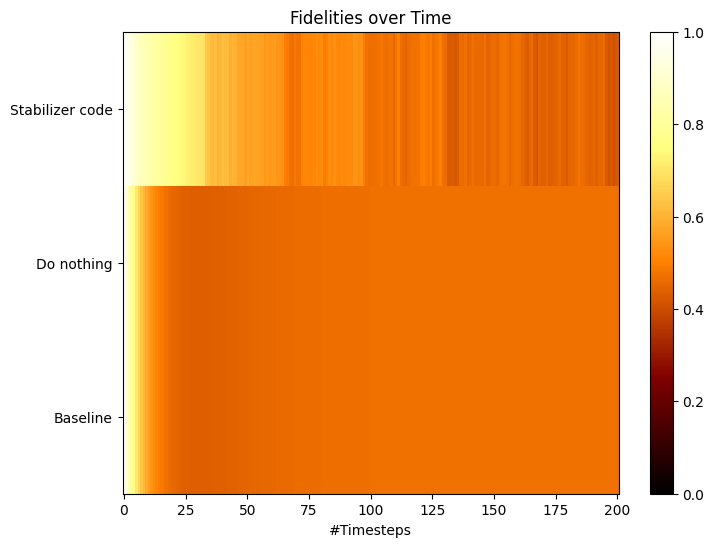

In [ ]:
from matplotlib import pyplot as plt

# Plot the fidelities over time in 2d colormap
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(
    fidelities_all,
    aspect='auto',
    origin='lower',
    cmap='afmhot',
    vmin=0.0,
    vmax=1.0,
    interpolation='none'
)
fig.colorbar(cax)
ax.set_xlabel('#Timesteps')
ax.set_yticks(jnp.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_title('Fidelities over Time')

print("scores = ", fidelities_all[:,:33].mean(axis=1))